Students:

- Antoine Ratouchniak
- Raphael Walker

# Deep Learning - Variational Auto-Encoder

In [1]:
import os, random
import numpy as np
import torch
import dataset_loader

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib as mpl

# Data loading and conversion

In [2]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

def build_torch_inputs(data):
    x, y = data
    ret = list()
    
    for i in range(x.shape[0]):
        input_tensor = torch.from_numpy(x[i]).reshape(1, -1)
        output_value = int(y[i])
        
        ret.append({
            "input_tensor": input_tensor,
            "output_value": output_value
        })
        
    return ret
        
train_data = build_torch_inputs(train_data)
dev_data = build_torch_inputs(dev_data)
test_data = build_torch_inputs(test_data)

In [3]:
# train_data is a list,
# each element is a dictionnary with two keys:
# - input_tensor: the input image as a row vector
# - output_value: the gold label

print(train_data[10]["input_tensor"].shape)
print(train_data[10]["output_value"])

torch.Size([1, 784])
4


In [4]:
# just a helper function
def build_batch(data):
    batch_inputs = torch.cat(
        [data["input_tensor"] for data in data],
        dim=0
    )

    labels = torch.LongTensor([data["output_value"] for data in data ])
    
    return batch_inputs, labels

# Network definition and training

In [5]:
def KL_N(mu, lss):
    # log sigma squared and mu will be of shape (batch x n).
    # This sum here should be understood as a sum over (n);
    return -0.5 * torch.sum(1 + lss - mu.pow(2) - lss.exp(), dim=1)

def reconstruction_loss(x, xh):
    return -torch.sum((x - xh).pow(2), dim=1)

In [71]:
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, h0, h1, output_dim):
        super().__init__()
        
        self.hidden_0 = nn.Linear(input_dim, h0)
        self.hidden_1 = nn.Linear(h0, h1)
        self.output_mu = nn.Linear(h1, output_dim)
        self.output_lss = nn.Linear(h1, output_dim)
                
        with torch.no_grad():
            
            nn.init.kaiming_uniform_(self.hidden_0.weight.data)
            nn.init.kaiming_uniform_(self.hidden_1.weight.data)
            nn.init.kaiming_uniform_(self.output_mu.weight.data)
            nn.init.kaiming_uniform_(self.output_lss.weight.data)
            
            self.hidden_0.bias.zero_()
            self.hidden_1.bias.zero_()
            self.output_mu.bias.zero_()
            self.output_lss.bias.zero_()
            
        
    def forward(self, inputs):
        z = self.hidden_0(inputs)
        z = torch.relu(z)
        z = self.hidden_1(z)
        z = torch.relu(z)

        return (self.output_mu(z), self.output_lss(z))
    
def init_for_relu(layer):
    if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
        nn.init.kaiming_uniform_(layer.weight.data, nonlinearity='relu')
        layer.bias.zero_()

In [72]:
def train(enc, dec, optimizer, train, valid=None, scheduler=None, epochs=2, batch_size=64, L=5):
    # Construct batches
    for epoch in range(epochs):
        enc.train()
        dec.train()
        random.shuffle(train)
        logging_loss = 0
        n_batches = 0
        for first_element in range(0, len(train), batch_size):
            # We don't care about labels
            batch, _ = build_batch(train[first_element:first_element + batch_size])
            optimizer.zero_grad()
            
            (mu, lss) = enc(batch)
            # Minimize KL divergence
            loss = KL_N(mu, lss)
            # L = number of monte carlo samples
            sigma = torch.sqrt(torch.exp(lss))
            for _ in range(L):
                noise = torch.normal(0, 1, mu.shape)
                z = mu + sigma * noise

                reconstructed = dec(z)
                # Maximize reconstruction likelihood
                loss = loss - (reconstruction_loss(batch, reconstructed) / L)
            
            batch_loss = loss.mean()
            batch_loss.backward()
            
            nn.utils.clip_grad_value_([*enc.parameters(), *dec.parameters()], 1.)

            optimizer.step()
            
            # Log training loss
            logging_loss += float(batch_loss) / 100.0
            n_batches += 1
            if n_batches == 100:
                print(f"Epoch {epoch:02d}, Batch {first_element//batch_size:03d}: TL {logging_loss:.3f}")
                logging_loss = 0
                n_batches = 0
        
        if scheduler is not None:
            scheduler.step()

In [73]:
IMAGE_DIM = train_data[0]["input_tensor"].shape[-1]
LATENT_DIM = 2

encoder = VAEEncoder(IMAGE_DIM, 64, 16, LATENT_DIM)
decoder = nn.Sequential(
    nn.Linear(LATENT_DIM, 16),
    nn.ReLU(),
    nn.Linear(16, 64),
    nn.ReLU(),
    nn.Linear(64, IMAGE_DIM),
    nn.Sigmoid())
# This just calls init_for_relu on each layer of the decoder
# Which uses kaiming init for each layer's weight, and zeroes the bias
with torch.no_grad():
    decoder.apply(init_for_relu)
    # Reinitialize the decoder's output for sigmoid activation
    nn.init.xavier_uniform_(decoder[-2].weight.data)

# Get the parameters of both the encoder and decoder
params = nn.ParameterList([*encoder.parameters(), *decoder.parameters()])
optimizer = torch.optim.Adam(params, lr=4e-3, weight_decay=1e-3)
# This will decay the learning rate by a factor of 0.93 every epoch
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.93)

train(encoder, decoder, optimizer, train_data, scheduler=scheduler, epochs=30)

Epoch 00, Batch 099: TL 58.669
Epoch 00, Batch 199: TL 45.930
Epoch 00, Batch 299: TL 43.925
Epoch 00, Batch 399: TL 43.022
Epoch 00, Batch 499: TL 42.410
Epoch 00, Batch 599: TL 42.095
Epoch 00, Batch 699: TL 41.295
Epoch 01, Batch 099: TL 41.072
Epoch 01, Batch 199: TL 40.631
Epoch 01, Batch 299: TL 40.925
Epoch 01, Batch 399: TL 40.447
Epoch 01, Batch 499: TL 40.106
Epoch 01, Batch 599: TL 40.167
Epoch 01, Batch 699: TL 39.790
Epoch 02, Batch 099: TL 39.726
Epoch 02, Batch 199: TL 39.458
Epoch 02, Batch 299: TL 39.018
Epoch 02, Batch 399: TL 39.347
Epoch 02, Batch 499: TL 39.621
Epoch 02, Batch 599: TL 39.352
Epoch 02, Batch 699: TL 39.541
Epoch 03, Batch 099: TL 38.790
Epoch 03, Batch 199: TL 39.186
Epoch 03, Batch 299: TL 38.676
Epoch 03, Batch 399: TL 38.808
Epoch 03, Batch 499: TL 38.788
Epoch 03, Batch 599: TL 38.896
Epoch 03, Batch 699: TL 38.683
Epoch 04, Batch 099: TL 38.691
Epoch 04, Batch 199: TL 38.487
Epoch 04, Batch 299: TL 38.434
Epoch 04, Batch 399: TL 38.540
Epoch 04

In [74]:
def train_ae(enc, dec, optimizer, train, valid=None, scheduler=None, epochs=2, batch_size=64):
    for epoch in range(epochs):
        enc.train()
        dec.train()
        random.shuffle(train)
        logging_loss = 0
        n_batches = 0
        for first_element in range(0, len(train), batch_size):
            batch, _ = build_batch(train[first_element:first_element + batch_size])
            optimizer.zero_grad()
            
            latent = enc(batch)
            rec = dec(latent)
            # We do this a weird way just so that the numerical scale of the loss will be the same as for the VAE
            loss = torch.sum((batch - rec).pow(2), axis=1)
            loss = torch.mean(loss)
            
            loss.backward()
            nn.utils.clip_grad_value_([*enc.parameters(), *dec.parameters()], 1.)
            optimizer.step()
        
        if scheduler is not None:
            scheduler.step()

# Both halves can be sequential, since there's only one head on the encoder
encoder_ae = nn.Sequential(
    nn.Linear(IMAGE_DIM, 64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, LATENT_DIM))
decoder_ae = nn.Sequential(
    nn.Linear(LATENT_DIM, 16),
    nn.ReLU(),
    nn.Linear(16, 64),
    nn.ReLU(),
    nn.Linear(64, IMAGE_DIM),
    nn.Sigmoid())
with torch.no_grad():
    encoder_ae.apply(init_for_relu)
    decoder_ae.apply(init_for_relu)
    nn.init.xavier_uniform_(decoder_ae[-2].weight.data)

params_ae = nn.ParameterList([*encoder_ae.parameters(), *decoder_ae.parameters()])
optimizer_ae = torch.optim.Adam(params_ae, lr=3e-3, weight_decay=1e-3)
scheduler_ae = torch.optim.lr_scheduler.StepLR(optimizer_ae, step_size = 1, gamma = 0.9)

train_ae(encoder_ae, decoder_ae, optimizer_ae, train_data, scheduler=scheduler_ae, epochs=20)

Epoch 00, Batch 099: TL 56.801
Epoch 00, Batch 199: TL 44.943
Epoch 00, Batch 299: TL 42.622
Epoch 00, Batch 399: TL 40.428
Epoch 00, Batch 499: TL 39.471
Epoch 00, Batch 599: TL 38.330
Epoch 00, Batch 699: TL 37.778
Epoch 01, Batch 099: TL 36.865
Epoch 01, Batch 199: TL 36.694
Epoch 01, Batch 299: TL 35.828
Epoch 01, Batch 399: TL 35.905
Epoch 01, Batch 499: TL 35.506
Epoch 01, Batch 599: TL 35.345
Epoch 01, Batch 699: TL 35.108
Epoch 02, Batch 099: TL 35.017
Epoch 02, Batch 199: TL 34.348
Epoch 02, Batch 299: TL 34.479
Epoch 02, Batch 399: TL 34.260
Epoch 02, Batch 499: TL 33.830
Epoch 02, Batch 599: TL 33.657
Epoch 02, Batch 699: TL 33.713
Epoch 03, Batch 099: TL 33.380
Epoch 03, Batch 199: TL 33.783
Epoch 03, Batch 299: TL 33.121
Epoch 03, Batch 399: TL 33.135
Epoch 03, Batch 499: TL 33.204
Epoch 03, Batch 599: TL 33.225
Epoch 03, Batch 699: TL 32.879
Epoch 04, Batch 099: TL 32.743
Epoch 04, Batch 199: TL 32.730
Epoch 04, Batch 299: TL 32.617
Epoch 04, Batch 399: TL 32.763
Epoch 04

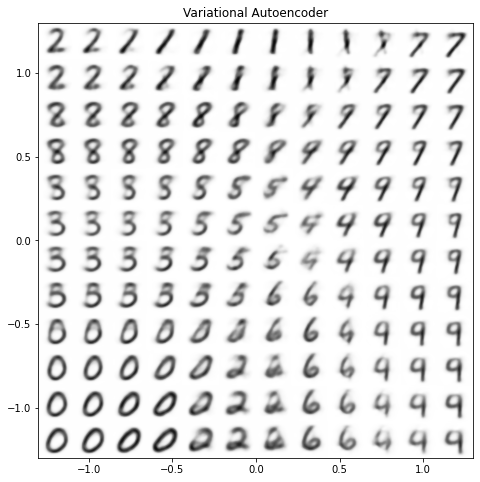

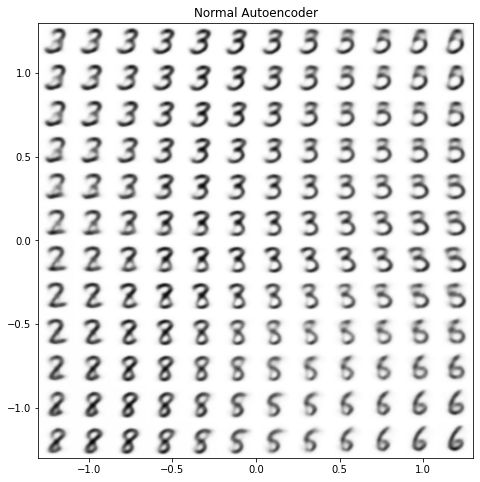

In [95]:
# The code to generate this plot comes from Alexander Van de Kleut:
# https://avandekleut.github.io/vae/
def plot_reconstructed(decoder, r0=(-1.3, 1.3), r1=(-1.3, 1.3), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]])
            x_hat = decoder(z)
            x_hat = x_hat.reshape(28, 28).detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
            
    plt.figure(figsize=(8, 8))
    plt.imshow(img, extent=[*r0, *r1], interpolation="bicubic", cmap="Greys")

plot_reconstructed(decoder)
plt.title("Variational Autoencoder")
plt.show()

plot_reconstructed(decoder_ae)
plt.title("Normal Autoencoder")
plt.show()

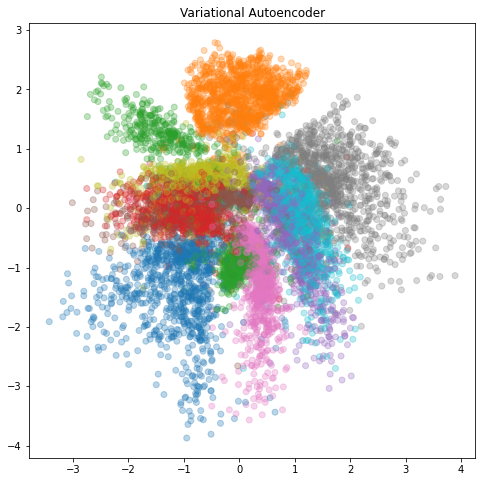

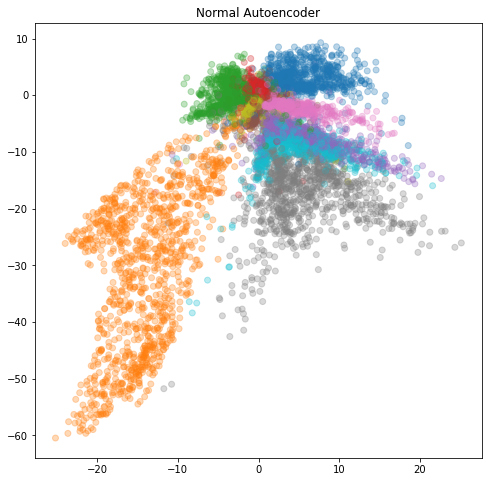

In [96]:
def visualize(encoder, dim, data, encoder_returns_tuple = True):
    encoder.eval()

    points = np.empty((len(data), dim))
    all_labels = np.empty((len(data)))
    batch_size = 64
    with torch.no_grad():
        for i in range(0, len(data), batch_size):
            batch, labels = build_batch(data[i:i+batch_size])
            encoder_out = encoder(batch)
            mu = encoder_out[0] if encoder_returns_tuple else encoder_out
            points[i:i+batch_size] = mu.numpy()
            all_labels[i:i+batch_size] = labels.numpy()

    plt.figure(figsize=(8, 8))
    plt.scatter(
        points[:,0], points[:, 1],
        c=mpl.cm.get_cmap("tab10")(all_labels / 10.),
        alpha=0.3
    )


visualize(encoder, 2, test_data)
plt.title("Variational Autoencoder")
plt.show()
visualize(encoder_ae, 2, test_data, encoder_returns_tuple=False)
plt.title("Normal Autoencoder")
plt.show()